In [2]:
%matplotlib inline
import random, numpy, math, copy, matplotlib.pyplot as plt
import numpy as np
class City:
    """coordinates of locations """
    def __init__(self, coords):
        self.x = int(coords[0])
        self.y = int(coords[1])
    
    def distance(self, city):
        """
        Euclidean distance between locations
        """
        xDis = (self.x - city.x)
        yDis = (self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    #def getCoord(self):
    #    return [self.x, self.y]

class TSP:
    def __init__(self, filename = None, cities_no = 10):
        """
        read input data
        """
        if filename is None:
            self.N = cities_no
            self.cities = [City(random.sample(range(100), 2)) for i in range(self.N)];
        else:
            self.N, self.cities = self.___read_TSP_file( filename)
        
    def ___read_TSP_file(self, filename):
        nodelist = []

        # Open input file
        with open(filename, 'r') as infile:

            # Read instance header
            Name = infile.readline().strip().split()[1] # NAME
            FileType = infile.readline().strip().split()[1] # TYPE
            Comment = infile.readline().strip().split()[1] # COMMENT
            Dimension = infile.readline().strip().split(":")[1] # DIMENSION
            EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
            infile.readline()

            # Read node list
            N = int(Dimension)
            for i in range(N):
                coords = infile.readline().strip().split()[1:]
                nodelist.append(City(coords))

        return N, nodelist
    
    def eval(self, tour):
        """computation of the tour cost"""
        val = 0
        for i in range(self.N-1):
            val += self.cities[tour[i]].distance(self.cities[tour[i+1]])
        val += self.cities[tour[0]].distance(self.cities[tour[self.N-1]])
        return val
    
    def displayTour(self, tour):
        """visualizing the tour"""
        
        plt.figure(figsize = (16,8))

        plt.axes()
        plt.plot([self.cities[tour[i % self.N]].x for i in range(self.N+1)], [self.cities[tour[i % self.N]].y for i in range(self.N+1)], 'bo-');
        plt.show()
    
    def generate_random_elem(self):
        """permutation encoding"""
        return random.sample(range(self.N), self.N);

    def simple_mutation(self, S):
        """2-opt perturbation"""
        i, j = random.sample(range(self.N),2)
        if i > j: i,j=j,i
        new_S = S.copy()
        for k in range((j-i)//2):
            new_S[i+k],new_S[j-k]=new_S[j-k],new_S[i+k]
        return new_S
    
    def recombination_one_cut_point(self, el1, el2):
        k = random.randint(0, self.N)
        child1 = el1[:k]
        child2 = el2[:k]
        child1.extend([x for x in el2 if x not in el1[:k]])
        child2.extend([x for x in el1 if x not in el2[:k]])
        return child1, child2

In [1]:
# Genetic Algorithm
class Element:
    def __init__(self, encoding, cost=0):
        self.encoding = encoding
        self.cost = cost
    def __repr__(self):
        return "[el={}, cost={}]".format(self.encoding, self.cost)
    
    def copy(self):
        return Element(self.encoding.copy(), self.cost)
        
def populationInitialization(prob, popSize):
    population = [Element(prob.generate_random_elem()) for i in range(popSize)]
    return population

def populationEvaluation(prob, population):
    for el in population: 
        el.cost = prob.eval(el.encoding)

def computeProbabilities(population):
    n = len(population)

    probabilities = []
    s = 0.0
    #print(population)
    for el in population:
        s += el.cost
    for el in population:
        probabilities.append(el.cost/s)
        
    return probabilities

def proportionalSelection(probabilities):
    k = 0
    s = probabilities[0]
    u = np.random.rand()
    while u > s:
        k += 1
        s = s + probabilities[k]
    return k

def tournamentSelection(population, populationSize):
    
    i1 = np.random.randint(0, populationSize)
    i2 = np.random.randint(0, populationSize)
    #print(populationSize,i1,i2)
    if population[i1].cost < population[i2].cost:
        return i1
    else:
        return i2
    
def rouletteWheel(probilities):
    n = len(probilities)
    
    indexes = []
    for i in range(n):
        indexes.append(proportionalSelection(probabilities))
        
    return indexes
        
def populationRecombination(recombinationFunc, prob, population, indexP1, indexP2):
    return getattr(prob, recombinationFunc)(population[indexP1].encoding, population[indexP2].encoding)
  
def new_population_build_byCopyChildren(population, children, limit=None):
    return children

def new_population_build_byParentsChildrenCompetition(population, children, value=None):
    popSize = len(population)
    newPop =[]
    for i in range(popSize):
        i1 = np.random.randint(0, 2*popSize)
        if i1 < popSize:
            el1 = population[i1]
        else:
            el1 = children[i1-popSize]

        i2 = np.random.randint(0, 2*popSize)
        if i2 < popSize:
            el2 = population[i2]
        else:
            el2 = children[i2-popSize]
            
        if el1.cost < el2.cost:
            newPop.append(el1.copy())
        else:
            newPop.append(el2.copy())
    return newPop

def GeneticAlgorithm(prob, recombinationFunc=None, mutationFunc=None, popSize=10, pm=0.1, maxIter = 100,
                    new_population_build = new_population_build_byCopyChildren, limit=None, selection='proportional'):
    population = populationInitialization(prob, popSize)
    populationEvaluation(prob, population)
    
    it = 0
    while it < maxIter:
        probabilities = computeProbabilities(population)
    
        children = []
        
        #croossover
        for i in range(popSize//2):
            if selection == 'tournament':
                i1 = tournamentSelection(population, popSize)
                i2 = tournamentSelection(population, popSize)
            else:
                i1 = proportionalSelection(probabilities)
                i2 = proportionalSelection(probabilities)
            c1, c2 = populationRecombination(recombinationFunc, prob, population, i1, i2)
            children.extend([Element(c1), Element(c2)])
        
        #mutation
        for i in range(popSize):
            if np.random.random(1)[0] < pm:  # mutation chance
              children[i].encoding = getattr(prob, mutationFunc)(children[i].encoding)
        
        
        populationEvaluation(prob, children)
        
        population = new_population_build(population, children, limit)
        
        it += 1
        
    best = min(population, key=lambda x: x.cost)
    # print("Best", best)
    return best


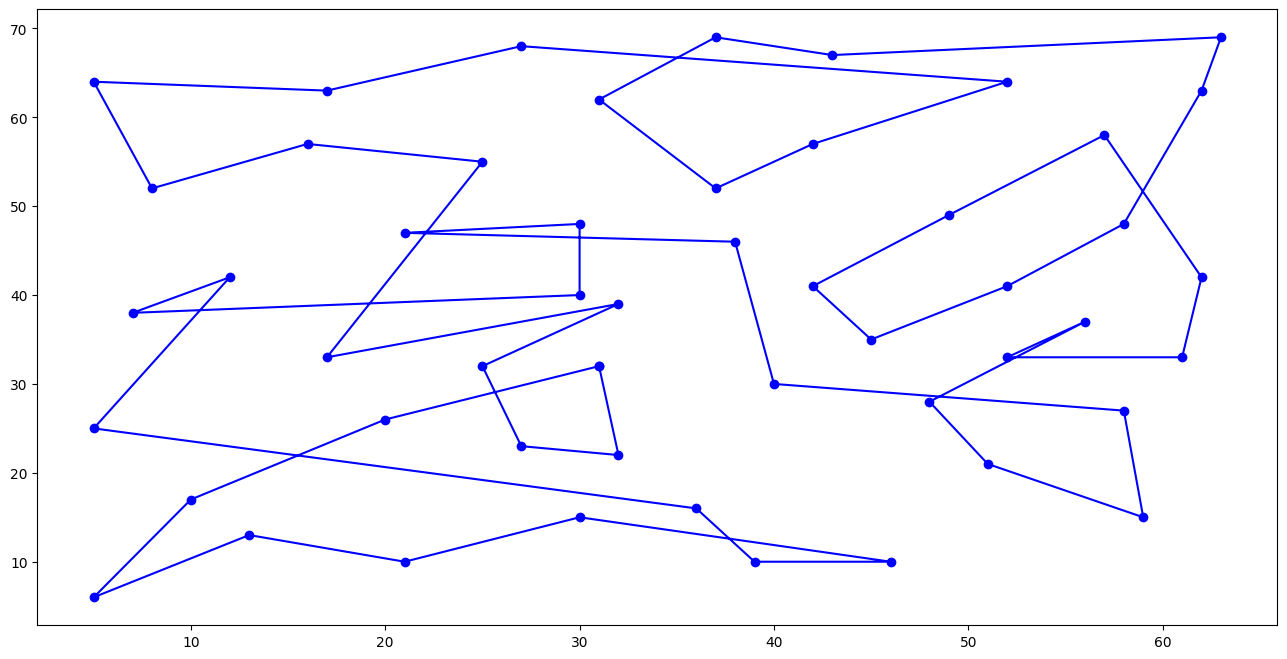

In [8]:
prob = TSP("../../data/tsp/eil51.tsp")
# prob = TSP()
best = GeneticAlgorithm(prob, recombinationFunc='recombination_one_cut_point', mutationFunc='simple_mutation', maxIter = 2000,
                        selection='tournament', new_population_build=new_population_build_byParentsChildrenCompetition)

prob.displayTour(best.encoding)